In [ ]:
library(MAAPER)

apa_atlas = readRDS('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/human.PAS.hg38.rds')
gtf_ref = '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes/genes_modified.gtf'

DMSO_bams = c('/data1/HTT_APA/170828_D00331_0257_BCBC0YANXX_Pugh_Laura/Pugh_Laura__G549_7day_DMSO/outs/modified.sorted.bam',
'/data1/HTT_APA/170828_D00331_0257_BCBC0YANXX_Pugh_Laura/Pugh_Laura__G561_7day_DMSO/outs/modified.sorted.bam')

Lily_bams = c('/data1/HTT_APA/170828_D00331_0257_BCBC0YANXX_Pugh_Laura/Pugh_Laura__G549_7day_LILY283/outs/modified.sorted.bam')


out_dir =  '/data1/HTT_APA/170828_D00331_0257_BCBC0YANXX_Pugh_Laura/MAAPER_out'
maaper(gtf_ref, apa_atlas, output_dir = out_dir, bam_c1 =DMSO_bams , bam_c2 = Lily_bams, read_len = 98, ncores = 32, num_pas_thre = 20, num_thre = 40)


In [2]:
library(ggplot2)
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyverse)
setwd('/data1/HTT_APA/170828_D00331_0257_BCBC0YANXX_Pugh_Laura/MAAPER_out/')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
# functions 

volcano_plot_2 <- function(fit, x, xlab = "Ln fold change", y, ylab = "-Log10 FDR",
    title = "LMCN data, metastatic vs non-metastatic", titleLabSize = 12, border = "full",
    pCutoff = 0.001, FCcutoff = 1.5, xlim = c(-3, 3), ylim = c(0, 10), pointsize= .2, top_n) {

    if (! x %in% names(fit)){
        stop(print(paste('The column', x, 'does not exist in the given dataframe.')))
    }

    if (! y %in% names(fit)){
        stop(print(paste('The column', y, 'does not exist in the given dataframe.')))
    }

    return(EnhancedVolcano::EnhancedVolcano(fit, lab = fit['transcript'], selectLab=top_n, x=x, xlab=xlab, y=y, ylab=ylab, title=title,
    titleLabSize=titleLabSize, border=border, pCutoff=pCutoff, FCcutoff=FCcutoff, xlim=xlim, ylim=ylim, pointSize=pointsize))
}

nmor_factor <- function (expression.data.frame, data.columns){
  gm_mean_z <- function(x){
    exp(sum(log(x)) / length(x))
  }
  edf <- expression.data.frame
  id.names <- names(edf)
  geo.mean.vec <- apply(edf[,data.columns], 1, function(x) gm_mean_z(x))
  ratios.df <- edf[,data.columns]/geo.mean.vec
  # Division by 0 gm_mean will create NAs here.
  normalization.factors <- apply(ratios.df, 2, function(x) median(x, na.rm=TRUE))
  return(normalization.factors)
}


count_pas <- function(genes,pas){
    c1_counts <- genes %>% select(contains('c1')) %>% mutate(C1_Allcounts=rowSums(.))  
    c2_counts <- genes %>% select(contains('c2')) %>% mutate(C2_Allcounts=rowSums(.), gene_name=genes$gene) 
    counts_table <- data.frame(c1_counts['C1_Allcounts'], c2_counts['C2_Allcounts'], c2_counts['gene_name'])
    colnames(pas) <- c('gene_name', 'pas', 'type', 'frac.c1', 'frac.c2')
    new_df <- inner_join(pas, counts_table, by="gene_name")
    new_df <- new_df %>% mutate(DMSO_PAcount=C1_Allcounts*frac.c1, LILY283_PAcount=C2_Allcounts*frac.c2)
    return(new_df)
}

In [4]:
genes_file <- read.csv("gene.txt", sep='\t')
pas_file <- read.csv("pas.txt", sep='\t')
out_file <- "pas_counts.txt"
df <- count_pas(genes_file, pas_file)
# df <- df %>% filter(gene_name=='HTT')
write.table(df, file=out_file, quote=F, sep='\t', row.names = F)
df

gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,DMSO_PAcount,LILY283_PAcount
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PLEKHN1,chr1:975865:+,3' most exon,0.4550,0.3450,218,353,99.1900,121.7850
PLEKHN1,chr1:975231:+,3' most exon,0.5450,0.6550,218,353,118.8100,231.2150
B3GALT6,chr1:1234959:+,3' most exon,0.3540,0.3690,1914,2398,677.5560,884.8620
B3GALT6,chr1:1234058:+,3' most exon,0.1740,0.1650,1914,2398,333.0360,395.6700
B3GALT6,chr1:1233729:+,3' most exon,0.4720,0.4650,1914,2398,903.4080,1115.0700
MIB2,chr1:1630605:+,3' most exon,0.6280,0.6480,553,646,347.2840,418.6080
MIB2,chr1:1617323:+,Intron,0.3720,0.3520,553,646,205.7160,227.3920
SKI,chr1:2310119:+,3' most exon,0.7930,0.7440,668,410,529.7240,305.0400
SKI,chr1:2308584:+,3' most exon,0.0947,0.1020,668,410,63.2596,41.8200


In [5]:
inp_df <- read.csv('pas_counts.txt', sep='\t')
out_file <-"APAlog_pas_count_input.txt"
inp_df

gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,DMSO_PAcount,LILY283_PAcount
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
PLEKHN1,chr1:975865:+,3' most exon,0.4550,0.3450,218,353,99.1900,121.7850
PLEKHN1,chr1:975231:+,3' most exon,0.5450,0.6550,218,353,118.8100,231.2150
B3GALT6,chr1:1234959:+,3' most exon,0.3540,0.3690,1914,2398,677.5560,884.8620
B3GALT6,chr1:1234058:+,3' most exon,0.1740,0.1650,1914,2398,333.0360,395.6700
B3GALT6,chr1:1233729:+,3' most exon,0.4720,0.4650,1914,2398,903.4080,1115.0700
MIB2,chr1:1630605:+,3' most exon,0.6280,0.6480,553,646,347.2840,418.6080
MIB2,chr1:1617323:+,Intron,0.3720,0.3520,553,646,205.7160,227.3920
SKI,chr1:2310119:+,3' most exon,0.7930,0.7440,668,410,529.7240,305.0400
SKI,chr1:2308584:+,3' most exon,0.0947,0.1020,668,410,63.2596,41.8200


In [6]:
sf <- nmor_factor(inp_df, c(8:9))
sf

DMSO_PAcount LILY283_PAcount 
      0.9826573       1.0261997

In [7]:
out_df <- inp_df %>% mutate(DMSO = DMSO_PAcount/sf[1], LILY283 = LILY283_PAcount/sf[2])
out_df

gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,DMSO_PAcount,LILY283_PAcount,DMSO,LILY283
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
PLEKHN1,chr1:975865:+,3' most exon,0.4550,0.3450,218,353,99.1900,121.7850,100.940586,118.675734
PLEKHN1,chr1:975231:+,3' most exon,0.5450,0.6550,218,353,118.8100,231.2150,120.906855,225.311900
B3GALT6,chr1:1234959:+,3' most exon,0.3540,0.3690,1914,2398,677.5560,884.8620,689.514059,862.270780
B3GALT6,chr1:1234058:+,3' most exon,0.1740,0.1650,1914,2398,333.0360,395.6700,338.913690,385.568235
B3GALT6,chr1:1233729:+,3' most exon,0.4720,0.4650,1914,2398,903.4080,1115.0700,919.352079,1086.601390
MIB2,chr1:1630605:+,3' most exon,0.6280,0.6480,553,646,347.2840,418.6080,353.413150,407.920610
MIB2,chr1:1617323:+,Intron,0.3720,0.3520,553,646,205.7160,227.3920,209.346643,221.586504
SKI,chr1:2310119:+,3' most exon,0.7930,0.7440,668,410,529.7240,305.0400,539.073000,297.252090
SKI,chr1:2308584:+,3' most exon,0.0947,0.1020,668,410,63.2596,41.8200,64.376057,40.752303


In [8]:
out_df_2 <- out_df %>% gather(sample, normalized_count, `LILY283`:`DMSO`) %>% arrange(pas, type, sample)
out_df_2

gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,DMSO_PAcount,LILY283_PAcount,sample,normalized_count
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>
SLC35A3,chr1:100015692:+,Intron,0.3110,0.3900,282,222,87.7020,86.5800,DMSO,89.24984
SLC35A3,chr1:100015692:+,Intron,0.3110,0.3900,282,222,87.7020,86.5800,LILY283,84.36954
SLC35A3,chr1:100023451:+,3' most exon,0.2320,0.1260,282,222,65.4240,27.9720,DMSO,66.57866
SLC35A3,chr1:100023451:+,3' most exon,0.2320,0.1260,282,222,65.4240,27.9720,LILY283,27.25785
SLC35A3,chr1:100023553:+,3' most exon,0.0916,0.0866,282,222,25.8312,19.2252,DMSO,26.28709
SLC35A3,chr1:100023553:+,3' most exon,0.0916,0.0866,282,222,25.8312,19.2252,LILY283,18.73437
SLC35A3,chr1:100026952:+,3' most exon,0.3110,0.2800,282,222,87.7020,62.1600,DMSO,89.24984
SLC35A3,chr1:100026952:+,3' most exon,0.3110,0.2800,282,222,87.7020,62.1600,LILY283,60.57301
SLC35A3,chr1:100035634:+,3' most exon,0.0542,0.1170,282,222,15.2844,25.9740,DMSO,15.55415


In [9]:
write.table(out_df_2, file=out_file, quote=F, sep='\t', row.names = F)   

In [10]:
## lets install the APAlog
BiocManager::install("Goodarzilab/APAlog", dependencies = TRUE)
library(APAlog)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing github package(s) 'Goodarzilab/APAlog'

Skipping install of 'APAlog' from a github remote, the SHA1 (e6522221) has not changed since last install.
  Use `force = TRUE` to force installation

Old packages: 'ade4', 'ape', 'argparse', 'askpass', 'babelgene', 'backports',
  'batchtools', 'bayesm', 'BH', 'BiocManager', 'BiocParallel', 'bit', 'blob',
  'bookdown', 'boot', 'brew', 'brio', 'broom', 'bslib', 'cachem', 'Cairo',
  'callr', 'car', 'carData', 'caret', 'checkmate', 'chron', 'class',
  'classInt', 'cli', 'clipr', 'cluster', 'codetools', 'coin', 'colorspace',
  'commonmark', 'compositions', 'config', 'conquer', 'cpp11', 'crayon',
  'credentials', 'crul', 'curl', 'cyclocomp', 'data.table', 'DBI', 'dbplyr',
  'deldir', 'DEoptimR', 'desc', 'DescT

In [11]:
## make a simle design table and run it for AST-PP table
design_table <- data.frame(sample=c('DMSO', 'LILY283'),
                           Condition=c('DMSO_control','LILY283_treatment'))
design_table$sample <- factor(design_table$sample, levels=c('DMSO', 'LILY283'))
design_table$Condition <- factor(design_table$Condition, levels=c('DMSO_control', 'LILY283_treatment'))
design_table

sample,Condition
<fct>,<fct>
DMSO,DMSO_control
LILY283,LILY283_treatment


In [12]:
pA_test_table <- out_df_2[, c(1,2,10,11)]
colnames(pA_test_table) <- c('transcript', 'pA.site','sample','count')
pA_test_table

transcript,pA.site,sample,count
<chr>,<chr>,<chr>,<dbl>
SLC35A3,chr1:100015692:+,DMSO,89.24984
SLC35A3,chr1:100015692:+,LILY283,84.36954
SLC35A3,chr1:100023451:+,DMSO,66.57866
SLC35A3,chr1:100023451:+,LILY283,27.25785
SLC35A3,chr1:100023553:+,DMSO,26.28709
SLC35A3,chr1:100023553:+,LILY283,18.73437
SLC35A3,chr1:100026952:+,DMSO,89.24984
SLC35A3,chr1:100026952:+,LILY283,60.57301
SLC35A3,chr1:100035634:+,DMSO,15.55415


In [13]:
pA_test_table$sample <- factor(pA_test_table$sample, levels=c('DMSO', 'LILY283'))
pA_test_table$transcript <- factor(pA_test_table$transcript)
pA_test_table$pA.site <- factor(pA_test_table$pA.site)


In [14]:
pA_test_table[sapply(pA_test_table, is.character)] <- lapply(pA_test_table[sapply(pA_test_table, is.character)], 
                                       as.factor)
head(pA_test_table)

,transcript,pA.site,sample,count
,<fct>,<fct>,<fct>,<dbl>
1,SLC35A3,chr1:100015692:+,DMSO,89.24984
2,SLC35A3,chr1:100015692:+,LILY283,84.36954
3,SLC35A3,chr1:100023451:+,DMSO,66.57866
4,SLC35A3,chr1:100023451:+,LILY283,27.25785
5,SLC35A3,chr1:100023553:+,DMSO,26.28709
6,SLC35A3,chr1:100023553:+,LILY283,18.73437


In [15]:
# remove zero counts
pA_test_table <- pA_test_table %>% filter(count>0)

In [16]:
pA_test_table_2 <- pA_test_table %>% filter(transcript %in% c('HTT', 'SLC35A3'))
pA_test_table_2

transcript,pA.site,sample,count
<fct>,<fct>,<fct>,<dbl>
SLC35A3,chr1:100015692:+,DMSO,89.249836
SLC35A3,chr1:100015692:+,LILY283,84.369545
SLC35A3,chr1:100023451:+,DMSO,66.578656
SLC35A3,chr1:100023451:+,LILY283,27.257853
SLC35A3,chr1:100023553:+,DMSO,26.287090
SLC35A3,chr1:100023553:+,LILY283,18.734366
SLC35A3,chr1:100026952:+,DMSO,89.249836
SLC35A3,chr1:100026952:+,LILY283,60.573007
SLC35A3,chr1:100035634:+,DMSO,15.554152


In [17]:
design_table

sample,Condition
<fct>,<fct>
DMSO,DMSO_control
LILY283,LILY283_treatment


In [18]:
fit.o_test <- APAlog::pA_logit_dev(pA_test_table_2,
                                     pA.site ~ Condition,
                                     design_table,
                                     "sample",  
                                     adj_method = "fdr")


[1] "99.9830047586676% of transcripts had <2 active pA sites and were removed"


In [19]:
fit.o_test %>% filter(transcript=='HTT')

transcript,p_devtest,fdr_p_devtest
<fct>,<dbl>,<dbl>
HTT,9.114586e-08,1.822917e-07


In [24]:
fit.op_test <- merge(fit.o_test, fit.p_test, by = "transcript")
fit.op_test

transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionLILY283_treatment,p_ConditionLILY283_treatment
<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3123953:+,-6.971392e-01,1.512730e-01,0.87482038,9.468794e-02
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3125021:+,1.882799e-01,6.191062e-01,-0.01059869,9.801512e-01
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3201079:+,-1.193957e-16,1.000000e+00,-0.60798937,1.904369e-01
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3240659:+,2.877451e+00,1.594565e-23,-2.09152219,4.916966e-10
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3243960:+,2.910530e+00,4.541144e-24,-1.76666132,1.003441e-07
HTT,9.114586e-08,1.822917e-07,chr4:3123953:+,chr4:3125021:+,8.854191e-01,6.052408e-02,-0.88541907,8.082831e-02
HTT,9.114586e-08,1.822917e-07,chr4:3123953:+,chr4:3201079:+,6.971392e-01,1.512730e-01,-1.48280975,6.012027e-03
HTT,9.114586e-08,1.822917e-07,chr4:3123953:+,chr4:3240659:+,3.574590e+00,6.542796e-19,-2.96634257,8.591239e-12
HTT,9.114586e-08,1.822917e-07,chr4:3123953:+,chr4:3243960:+,3.607669e+00,3.003234e-19,-2.64148170,8.835588e-10


In [21]:
volcano_plot_2 <- function(fit, x, xlab = "Ln fold change", y, ylab = "-Log10 FDR",
    title = "", titleLabSize = 12, border = "full",
    pCutoff = 0.001, FCcutoff = 1.5, xlim = c(-3, 3), ylim = c(0, 10), pointsize= .2, top_n) {

    if (! x %in% names(fit)){
        stop(print(paste('The column', x, 'does not exist in the given dataframe.')))
    }

    if (! y %in% names(fit)){
        stop(print(paste('The column', y, 'does not exist in the given dataframe.')))
    }

    return(EnhancedVolcano::EnhancedVolcano(fit, lab = fit['ID'], selectLab=top_n, x=x, xlab=xlab, y=y, ylab=ylab, title=title,
    titleLabSize=titleLabSize, border=border, pCutoff=pCutoff, FCcutoff=FCcutoff, xlim=xlim, ylim=ylim, pointSize=pointsize))
}

In [25]:
htt_res = fit.op_test %>% filter(transcript=='HTT')
htt_res

transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionLILY283_treatment,p_ConditionLILY283_treatment
<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3123953:+,-6.971392e-01,1.512730e-01,0.87482038,9.468794e-02
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3125021:+,1.882799e-01,6.191062e-01,-0.01059869,9.801512e-01
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3201079:+,-1.193957e-16,1.000000e+00,-0.60798937,1.904369e-01
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3240659:+,2.877451e+00,1.594565e-23,-2.09152219,4.916966e-10
HTT,9.114586e-08,1.822917e-07,chr4:3122753:+,chr4:3243960:+,2.910530e+00,4.541144e-24,-1.76666132,1.003441e-07
HTT,9.114586e-08,1.822917e-07,chr4:3123953:+,chr4:3125021:+,8.854191e-01,6.052408e-02,-0.88541907,8.082831e-02
HTT,9.114586e-08,1.822917e-07,chr4:3123953:+,chr4:3201079:+,6.971392e-01,1.512730e-01,-1.48280975,6.012027e-03
HTT,9.114586e-08,1.822917e-07,chr4:3123953:+,chr4:3240659:+,3.574590e+00,6.542796e-19,-2.96634257,8.591239e-12
HTT,9.114586e-08,1.822917e-07,chr4:3123953:+,chr4:3243960:+,3.607669e+00,3.003234e-19,-2.64148170,8.835588e-10


In [26]:
for (i in 1:15){
    ref = htt_res[i, 'ref_site']
    alt = htt_res[i, 'alt_site']
    chr = gsub("(.*):.*:.*", "\\1", ref)
    start = gsub(".*:(.*):.*", "\\1", ref)
    end = gsub(".*:(.*):.*", "\\1", alt)
    ID = paste0(chr, ':', start, '-', end)
    print(ID)
    htt_res[i, 'ID'] = ID
}

[1] "chr4:3122753-3123953"
[1] "chr4:3122753-3125021"
[1] "chr4:3122753-3201079"
[1] "chr4:3122753-3240659"
[1] "chr4:3122753-3243960"
[1] "chr4:3123953-3125021"
[1] "chr4:3123953-3201079"
[1] "chr4:3123953-3240659"
[1] "chr4:3123953-3243960"
[1] "chr4:3125021-3201079"
[1] "chr4:3125021-3240659"
[1] "chr4:3125021-3243960"
[1] "chr4:3201079-3240659"
[1] "chr4:3201079-3243960"
[1] "chr4:3240659-3243960"


In [147]:
pas_file <- read.csv("pas.txt", sep='\t')
pas_file %>% filter(gene=='HTT')

gene,pas,type,frac.c1,frac.c2
<chr>,<chr>,<chr>,<dbl>,<dbl>
HTT,chr4:3243960:+,3' most exon,0.4610,0.3390
HTT,chr4:3240659:+,3' most exon,0.4460,0.2370
HTT,chr4:3125021:+,Intron,0.0303,0.1290
HTT,chr4:3201079:+,Intron,0.0251,0.0588
HTT,chr4:3122753:+,Intron,0.0251,0.1080
HTT,chr4:3123953:+,Intron,0.0125,0.1290


Loading required package: ggrepel



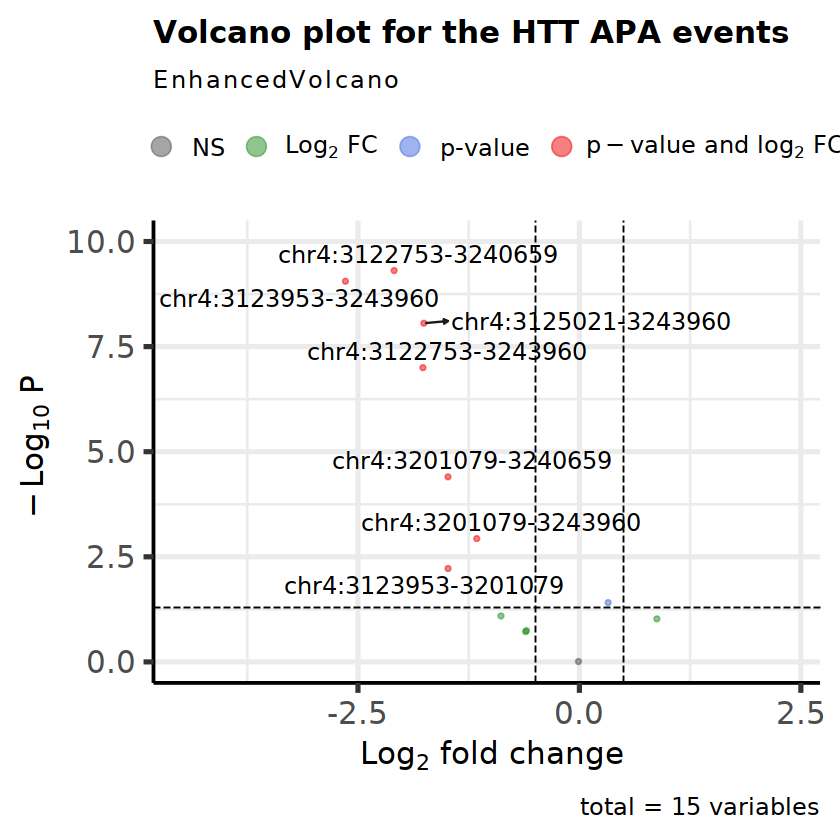

In [27]:
library(EnhancedVolcano)
library(ggplot2)

EnhancedVolcano(
    htt_res,
    lab = htt_res$ID,
    x = 'b_ConditionLILY283_treatment',
    y = 'p_ConditionLILY283_treatment',
    title = 'Volcano plot for the HTT APA events',
    pCutoff = 0.05,
    FCcutoff = .5,
    ylim = c(0, 10),
    pointSize = 1,
    drawConnectors = TRUE,
    )